In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
import torchaudio.transforms as T
from torchvision.models import resnet18
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')

In [4]:
data_dir = '//kaggle/input/heartbeat-sounds/set_b'
file_csv = '/kaggle/input/heartbeat-sounds/set_b.csv'

In [5]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [6]:
NUM_SAMPLES = 65500
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 10
train_size = 0.8

In [7]:
recordings_old = sorted(os.listdir(data_dir))

In [8]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [9]:
len(recordings)

638

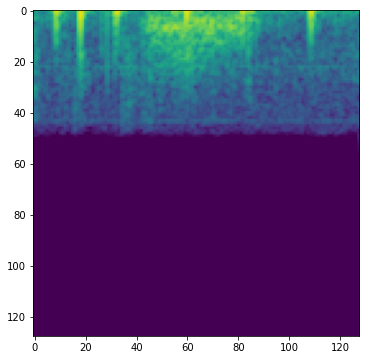

In [10]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [11]:
image_size = melspec.shape
image_size

(128, 128)

In [12]:
melspec = torch.tensor(melspec)
melspec = torch.stack([melspec, melspec, melspec])

In [13]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 12):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 12):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(12)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 12)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [14]:
def get_spectrograms(filename):
    y, _ = librosa.load(filename, sr = sr)
    count = len(y) // NUM_SAMPLES
    mel_spectrograms = []
    for i in range(count):
        samples = y[i * NUM_SAMPLES:(i + 1) * NUM_SAMPLES]
        melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        mel_spectrograms.append(torch.tensor(melspec, dtype=torch.float32))

    return mel_spectrograms, count

In [15]:
class HeartbeatSounds(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
data = []
labels = []
for i in range(len(recordings)):
    if 'normal' in recordings[i]:
        label = 0
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'extrastole' in recordings[i]:
        label = 1
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'murmur' in recordings[i]:
        label = 2
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)

In [17]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [18]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [19]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No Augmentation

In [20]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = False, aug_type = 'No', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch: 0
Train
0.7716247958262067
TEST
loss: 0.9661614474796113
accuracy: 0.5555555555555556
******************
epoch: 1
Train
0.5476595069606499
TEST
loss: 1.7259894526194013
accuracy: 0.44761904761904764
******************
epoch: 2
Train
0.49539880813162324
TEST
loss: 1.0250310492894006
accuracy: 0.6857142857142857
******************
epoch: 3
Train
0.44067312444458884
TEST
loss: 0.5783740528046138
accuracy: 0.7587301587301587
******************
epoch: 4
Train
0.39620554051861295
TEST
loss: 0.6875617719831921
accuracy: 0.7174603174603175
******************
epoch: 5
Train
0.325760206845282
TEST
loss: 0.826202848979405
accuracy: 0.7492063492063492
******************
epoch: 6
Train
0.2620595740931104
TEST
loss: 0.9137539897646223
accuracy: 0.6126984126984127
******************
epoch: 7
Train
0.23909008654457317
TEST
loss: 0.9003859743239387
accuracy: 0.7777777777777778
******************
epoch: 8
Train
0.2434525263745033
TEST
loss: 1.0444316023872011
accuracy: 0.6603174603174603
********

In [21]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8121827411167513


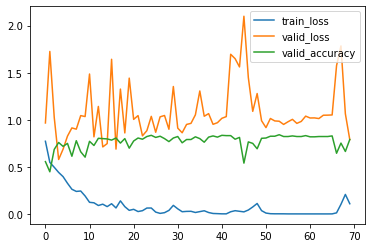

In [22]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [23]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.811804940058562
TEST
loss: 0.8527072497776577
accuracy: 0.6698412698412698
******************
epoch: 1
Train
0.573187203185723
TEST
loss: 0.5251146250300938
accuracy: 0.8031746031746032
******************
epoch: 2
Train
0.49165962114515904
TEST
loss: 0.7818241318066915
accuracy: 0.7619047619047619
******************
epoch: 3
Train
0.49183293990051113
TEST
loss: 0.6310243101347061
accuracy: 0.7777777777777778
******************
epoch: 4
Train
0.41963867086849105
TEST
loss: 0.5298588362951128
accuracy: 0.8158730158730159
******************
epoch: 5
Train
0.41011325066955057
TEST
loss: 0.9155768256338815
accuracy: 0.5841269841269842
******************
epoch: 6
Train
0.38942906286528983
TEST
loss: 0.6373187307327512
accuracy: 0.765079365079365
******************
epoch: 7
Train
0.35178983604462966
TEST
loss: 1.7305060348813497
accuracy: 0.6825396825396826
******************
epoch: 8
Train
0.3248752242189442
TEST
loss: 0.8673481042422946
accurac

In [24]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8401015228426396


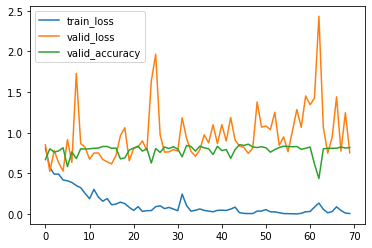

In [25]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [26]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8079785124662853
TEST
loss: 0.738016252479856
accuracy: 0.780952380952381
******************
epoch: 1
Train
0.6108094906882694
TEST
loss: 0.7453478071424696
accuracy: 0.7523809523809524
******************
epoch: 2
Train
0.5066671465198799
TEST
loss: 0.8561537576100183
accuracy: 0.7682539682539683
******************
epoch: 3
Train
0.515202667715059
TEST
loss: 0.5411486360761855
accuracy: 0.8063492063492064
******************
epoch: 4
Train
0.45280846630277094
TEST
loss: 0.466723552771977
accuracy: 0.7841269841269841
******************
epoch: 5
Train
0.38673640982890717
TEST
loss: 0.8963533327693031
accuracy: 0.5873015873015873
******************
epoch: 6
Train
0.40389877803937324
TEST
loss: 0.5616108347499181
accuracy: 0.8253968253968254
******************
epoch: 7
Train
0.327654352587684
TEST
loss: 1.1454016201079837
accuracy: 0.6984126984126984
******************
epoch: 8
Train
0.33341575937672585
TEST
loss: 0.636171352390259
accuracy: 0.

In [27]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.817258883248731


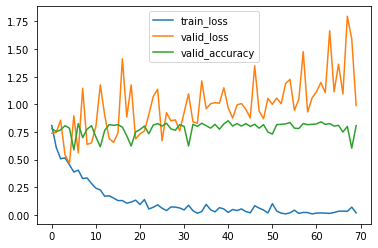

In [28]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [29]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.7731474236517885
TEST
loss: 0.5301033344533709
accuracy: 0.7936507936507936
******************
epoch: 1
Train
0.5057244648812212
TEST
loss: 1.6382432509982396
accuracy: 0.20952380952380953
******************
epoch: 2
Train
0.48006276169686773
TEST
loss: 1.0806911994540502
accuracy: 0.6857142857142857
******************
epoch: 3
Train
0.48635232145583657
TEST
loss: 0.8154943364007132
accuracy: 0.653968253968254
******************
epoch: 4
Train
0.39733482557596717
TEST
loss: 0.7072533671818082
accuracy: 0.8063492063492064
******************
epoch: 5
Train
0.373147362158164
TEST
loss: 1.3337972830212306
accuracy: 0.5365079365079365
******************
epoch: 6
Train
0.32202020318286584
TEST
loss: 0.6104379262242998
accuracy: 0.7619047619047619
******************
epoch: 7
Train
0.28384532535639523
TEST
loss: 0.5752545171313815
accuracy: 0.780952380952381
******************
epoch: 8
Train
0.17045434424098851
TEST
loss: 0.6783087809880575
accura

In [30]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


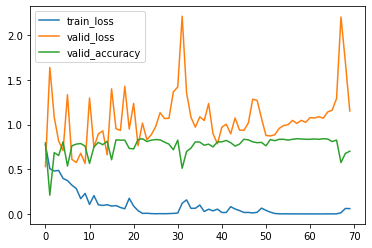

In [31]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [32]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.805851454816232
TEST
loss: 1.0869692405064901
accuracy: 0.726984126984127
******************
epoch: 1
Train
0.5638125655999536
TEST
loss: 0.7773777360007876
accuracy: 0.7428571428571429
******************
epoch: 2
Train
0.5046046613415998
TEST
loss: 0.5652897293605502
accuracy: 0.7904761904761904
******************
epoch: 3
Train
0.47455230632218415
TEST
loss: 0.9226639715452043
accuracy: 0.5619047619047619
******************
epoch: 4
Train
0.4073775782293512
TEST
loss: 0.6619333689174954
accuracy: 0.7873015873015873
******************
epoch: 5
Train
0.3362920101291135
TEST
loss: 0.4740569932120187
accuracy: 0.8063492063492064
******************
epoch: 6
Train
0.2376540331635994
TEST
loss: 1.0126025479937357
accuracy: 0.7142857142857143
******************
epoch: 7
Train
0.24988442294838129
TEST
loss: 0.910267274341886
accuracy: 0.7682539682539683
******************
epoch: 8
Train
0.2503034881315386
TEST
loss: 0.8088977953744313
accuracy: 0

In [33]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


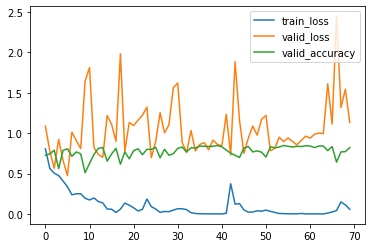

In [34]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [35]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8540264351487254
TEST
loss: 0.7048991519307334
accuracy: 0.7301587301587301
******************
epoch: 1
Train
0.6217904443112132
TEST
loss: 0.550565807213859
accuracy: 0.7904761904761904
******************
epoch: 2
Train
0.5560452682428458
TEST
loss: 0.543302531658657
accuracy: 0.7904761904761904
******************
epoch: 3
Train
0.556050905403019
TEST
loss: 0.5488393501629905
accuracy: 0.7714285714285715
******************
epoch: 4
Train
0.5189158107620843
TEST
loss: 0.48559957449398344
accuracy: 0.8222222222222222
******************
epoch: 5
Train
0.4875750363796263
TEST
loss: 0.5760530265550765
accuracy: 0.7968253968253968
******************
epoch: 6
Train
0.46242459254476925
TEST
loss: 0.506961962438765
accuracy: 0.8031746031746032
******************
epoch: 7
Train
0.4387636312991499
TEST
loss: 0.7597044305195884
accuracy: 0.7619047619047619
******************
epoch: 8
Train
0.4584240543643476
TEST
loss: 0.8067746743323311
accuracy: 0.

In [36]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8807106598984772


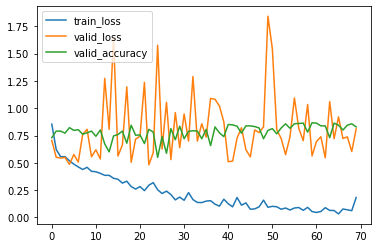

In [37]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [38]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.0150113630806104
TEST
loss: 1.342312973264664
accuracy: 0.5714285714285714
******************
epoch: 1
Train
0.7708721097212542
TEST
loss: 0.7412087960848732
accuracy: 0.7238095238095238
******************
epoch: 2
Train
0.7694484942294568
TEST
loss: 0.6189781171934945
accuracy: 0.7841269841269841
******************
epoch: 3
Train
0.685047972334861
TEST
loss: 0.6257418452747284
accuracy: 0.7619047619047619
******************
epoch: 4
Train
0.6630754036691285
TEST
loss: 0.6470620942494226
accuracy: 0.7714285714285715
******************
epoch: 5
Train
0.6620157800372202
TEST
loss: 0.7010612219099015
accuracy: 0.7714285714285715
******************
epoch: 6
Train
0.6698416155704532
TEST
loss: 0.609226894189441
accuracy: 0.8
******************
epoch: 7
Train
0.6064638421116981
TEST
loss: 0.661661406168862
accuracy: 0.7746031746031746
******************
epoch: 8
Train
0.6177612067073749
TEST
loss: 0.643232294302138
accuracy: 0.7936507936507936
*

In [39]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8223350253807107


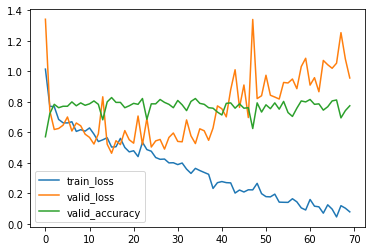

In [40]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [41]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.9468497601267456
TEST
loss: 2.6929366876208594
accuracy: 0.29523809523809524
******************
epoch: 1
Train
0.7489725180189225
TEST
loss: 4.053581234765431
accuracy: 0.6761904761904762
******************
epoch: 2
Train
0.6420679485352859
TEST
loss: 1.2396342799777076
accuracy: 0.6158730158730159
******************
epoch: 3
Train
0.6002217738565895
TEST
loss: 0.8675441092915005
accuracy: 0.6253968253968254
******************
epoch: 4
Train
0.5630404105775407
TEST
loss: 2.3501428331647602
accuracy: 0.6761904761904762
******************
epoch: 5
Train
0.5538490760458945
TEST
loss: 1.1537148157755535
accuracy: 0.6031746031746031
******************
epoch: 6
Train
0.5206947829914623
TEST
loss: 0.6530612470611693
accuracy: 0.7873015873015873
******************
epoch: 7
Train
0.4714661926575555
TEST
loss: 1.049166964916956
accuracy: 0.7365079365079366
******************
epoch: 8
Train
0.4833277896626588
TEST
loss: 0.6957758909180051
accuracy: 0

In [42]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8121827411167513


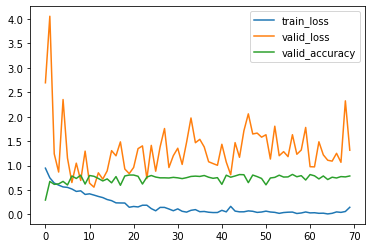

In [43]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [44]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.7672519797934153
TEST
loss: 0.7078072778762333
accuracy: 0.6634920634920635
******************
epoch: 1
Train
0.5844551489834183
TEST
loss: 0.5305372635523479
accuracy: 0.8
******************
epoch: 2
Train
0.5040754744512302
TEST
loss: 0.5252679974313766
accuracy: 0.8063492063492064
******************
epoch: 3
Train
0.47631290704130275
TEST
loss: 0.5694998260528322
accuracy: 0.8031746031746032
******************
epoch: 4
Train
0.42111329962754646
TEST
loss: 1.14598724577162
accuracy: 0.5746031746031746
******************
epoch: 5
Train
0.431102982108985
TEST
loss: 0.5036910924646589
accuracy: 0.8285714285714286
******************
epoch: 6
Train
0.3801438623567343
TEST
loss: 1.1491843424146138
accuracy: 0.7396825396825397
******************
epoch: 7
Train
0.34618104668814953
TEST
loss: 0.8728766422423105
accuracy: 0.6666666666666666
******************
epoch: 8
Train
0.27265614401948557
TEST
loss: 0.9928987521973868
accuracy: 0.771428571428

In [45]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.799492385786802


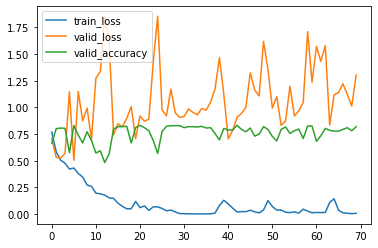

In [46]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [47]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8198141062231268
TEST
loss: 0.9102833901132856
accuracy: 0.638095238095238
******************
epoch: 1
Train
0.6008304408658962
TEST
loss: 1.5087486342778282
accuracy: 0.47619047619047616
******************
epoch: 2
Train
0.49944355347688657
TEST
loss: 0.6343076302891686
accuracy: 0.7841269841269841
******************
epoch: 3
Train
0.4350148168606262
TEST
loss: 1.0973537535894484
accuracy: 0.6285714285714286
******************
epoch: 4
Train
0.40914876176735254
TEST
loss: 2.657323756293645
accuracy: 0.28888888888888886
******************
epoch: 5
Train
0.3971206569264482
TEST
loss: 0.8955418410755339
accuracy: 0.6158730158730159
******************
epoch: 6
Train
0.4243501963077603
TEST
loss: 0.641478821587941
accuracy: 0.8
******************
epoch: 7
Train
0.29929488343412297
TEST
loss: 1.1164914305247957
accuracy: 0.4222222222222222
******************
epoch: 8
Train
0.29124821624862857
TEST
loss: 0.6320848179241968
accuracy: 0.8190476190

In [48]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


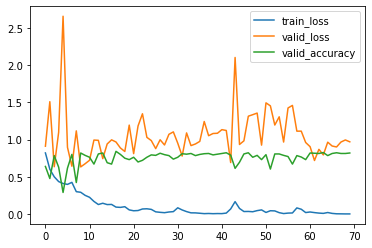

In [49]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [50]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.7682181525268282
TEST
loss: 0.6275673391327026
accuracy: 0.7873015873015873
******************
epoch: 1
Train
0.6182166176527809
TEST
loss: 0.6459543809058175
accuracy: 0.7873015873015873
******************
epoch: 2
Train
0.5649983514576701
TEST
loss: 0.5608041952526759
accuracy: 0.7904761904761904
******************
epoch: 3
Train
0.5383070750876586
TEST
loss: 0.537633138421982
accuracy: 0.7746031746031746
******************
epoch: 4
Train
0.5172688881493069
TEST
loss: 0.9334880588546631
accuracy: 0.638095238095238
******************
epoch: 5
Train
0.483926297583402
TEST
loss: 0.5666188357368348
accuracy: 0.7841269841269841
******************
epoch: 6
Train
0.46788331078005935
TEST
loss: 0.503731432888243
accuracy: 0.8253968253968254
******************
epoch: 7
Train
0.43955368021350705
TEST
loss: 0.6787319039541577
accuracy: 0.8031746031746032
******************
epoch: 8
Train
0.456300768365076
TEST
loss: 0.6091114312883408
accuracy: 0.7

In [51]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.868020304568528


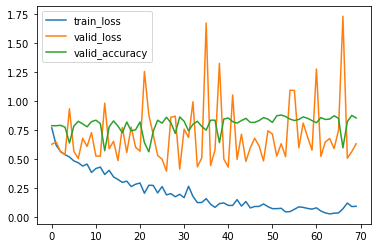

In [52]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [53]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.0474077907699362
TEST
loss: 0.6886497437007844
accuracy: 0.7365079365079366
******************
epoch: 1
Train
0.7382816543789303
TEST
loss: 2.4317625303117056
accuracy: 0.2761904761904762
******************
epoch: 2
Train
0.7466066119403855
TEST
loss: 0.7624602113451276
accuracy: 0.6571428571428571
******************
epoch: 3
Train
0.6909656609875329
TEST
loss: 0.7214908662296476
accuracy: 0.7365079365079366
******************
epoch: 4
Train
0.633920335315162
TEST
loss: 0.5529584744619944
accuracy: 0.7968253968253968
******************
epoch: 5
Train
0.6125331475111678
TEST
loss: 0.576627220426287
accuracy: 0.780952380952381
******************
epoch: 6
Train
0.5966162905984687
TEST
loss: 0.5426451264865815
accuracy: 0.8
******************
epoch: 7
Train
0.5875276936909052
TEST
loss: 0.5497239885822175
accuracy: 0.7968253968253968
******************
epoch: 8
Train
0.6636516926802748
TEST
loss: 1.1412428138748048
accuracy: 0.6761904761904762

In [54]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8248730964467005


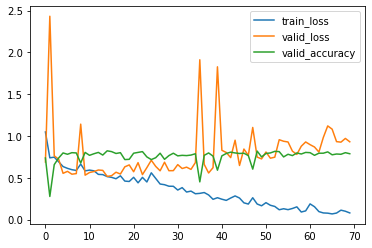

In [55]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [56]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.757071200915042
TEST
loss: 0.5792022464767335
accuracy: 0.7873015873015873
******************
epoch: 1
Train
0.6083171687327841
TEST
loss: 0.9870368730454218
accuracy: 0.5492063492063493
******************
epoch: 2
Train
0.5573629012081337
TEST
loss: 0.6291480569612412
accuracy: 0.7682539682539683
******************
epoch: 3
Train
0.5400864953460723
TEST
loss: 0.5617831737276108
accuracy: 0.7682539682539683
******************
epoch: 4
Train
0.5177933015787384
TEST
loss: 0.4560812749559917
accuracy: 0.8317460317460318
******************
epoch: 5
Train
0.44801271331035686
TEST
loss: 0.8585624168789576
accuracy: 0.6793650793650794
******************
epoch: 6
Train
0.45364512906744897
TEST
loss: 0.4692266099036686
accuracy: 0.834920634920635
******************
epoch: 7
Train
0.42305950819262444
TEST
loss: 1.1382394677116758
accuracy: 0.7238095238095238
******************
epoch: 8
Train
0.45165725517500194
TEST
loss: 0.5514731155501471
accuracy

In [57]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8629441624365483


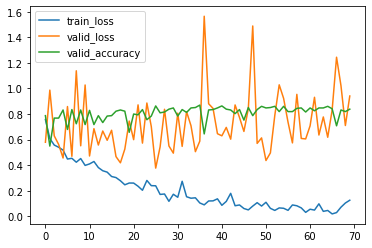

In [58]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [59]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.9818961134593197
TEST
loss: 0.6654650542471144
accuracy: 0.765079365079365
******************
epoch: 1
Train
0.7470710350702072
TEST
loss: 1.0493962777985466
accuracy: 0.5111111111111111
******************
epoch: 2
Train
0.7001117697966487
TEST
loss: 0.8361411976435827
accuracy: 0.7365079365079366
******************
epoch: 3
Train
0.6259651046314345
TEST
loss: 0.6796987508970593
accuracy: 0.7365079365079366
******************
epoch: 4
Train
0.604115265195951
TEST
loss: 0.5733089409177266
accuracy: 0.7904761904761904
******************
epoch: 5
Train
0.6024959913267798
TEST
loss: 0.5427493929862977
accuracy: 0.7873015873015873
******************
epoch: 6
Train
0.5934984766840461
TEST
loss: 0.5559324803806487
accuracy: 0.8158730158730159
******************
epoch: 7
Train
0.572612791898423
TEST
loss: 0.4847405233080425
accuracy: 0.8285714285714286
******************
epoch: 8
Train
0.5669191393282226
TEST
loss: 0.6334480512709845
accuracy: 0.7

In [60]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8223350253807107


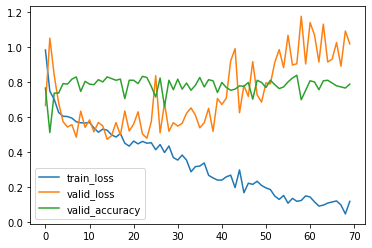

In [61]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [62]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.833129155673708
TEST
loss: 0.6457341155362508
accuracy: 0.7777777777777778
******************
epoch: 1
Train
0.6033873437556887
TEST
loss: 0.694901868842897
accuracy: 0.7682539682539683
******************
epoch: 2
Train
0.5612416287279015
TEST
loss: 1.0567708781787328
accuracy: 0.5111111111111111
******************
epoch: 3
Train
0.5046563826448108
TEST
loss: 0.6824004706882295
accuracy: 0.7174603174603175
******************
epoch: 4
Train
0.47857236021847077
TEST
loss: 1.5196348122188024
accuracy: 0.44761904761904764
******************
epoch: 5
Train
0.43468053176158755
TEST
loss: 0.6039496122844635
accuracy: 0.7365079365079366
******************
epoch: 6
Train
0.3754587930710757
TEST
loss: 0.49383942967369443
accuracy: 0.819047619047619
******************
epoch: 7
Train
0.3452069629176066
TEST
loss: 0.6707006164959499
accuracy: 0.8222222222222222
******************
epoch: 8
Train
0.3260655164765971
TEST
loss: 0.634332317397708
accuracy: 

In [63]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8350253807106599


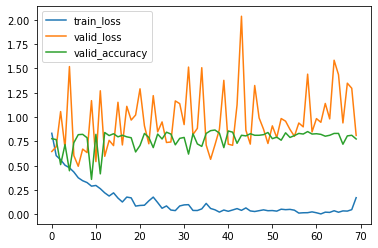

In [64]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [65]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.7615836003737567
TEST
loss: 1.143803096006787
accuracy: 0.6158730158730159
******************
epoch: 1
Train
0.5796759147152625
TEST
loss: 0.6539820517812457
accuracy: 0.780952380952381
******************
epoch: 2
Train
0.5346784099309193
TEST
loss: 0.560719531112247
accuracy: 0.8063492063492064
******************
epoch: 3
Train
0.450625888831659
TEST
loss: 0.9193425492634849
accuracy: 0.5714285714285714
******************
epoch: 4
Train
0.40914007330149105
TEST
loss: 0.6217897619519915
accuracy: 0.8063492063492064
******************
epoch: 5
Train
0.38302431460928593
TEST
loss: 1.243640074654231
accuracy: 0.5396825396825397
******************
epoch: 6
Train
0.33556521615876006
TEST
loss: 1.0387727631462944
accuracy: 0.7365079365079366
******************
epoch: 7
Train
0.28125696062947003
TEST
loss: 0.8436750680681259
accuracy: 0.7492063492063492
******************
epoch: 8
Train
0.3024760496294432
TEST
loss: 0.6167753503436134
accuracy: 0

In [66]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8248730964467005


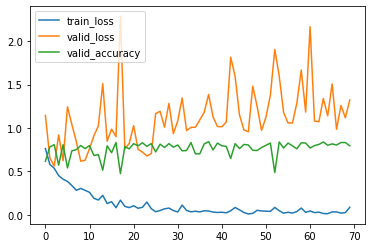

In [67]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [68]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.7571614920572216
TEST
loss: 0.646325032862406
accuracy: 0.7174603174603175
******************
epoch: 1
Train
0.5704333511394958
TEST
loss: 0.5406956805123223
accuracy: 0.8063492063492064
******************
epoch: 2
Train
0.5180726037127712
TEST
loss: 0.7518079967725845
accuracy: 0.6730158730158731
******************
epoch: 3
Train
0.5030926292713338
TEST
loss: 0.8565082928491017
accuracy: 0.6603174603174603
******************
epoch: 4
Train
0.4128081528935951
TEST
loss: 0.5865837661992936
accuracy: 0.8
******************
epoch: 5
Train
0.3714083453745384
TEST
loss: 0.49477181150799704
accuracy: 0.7968253968253968
******************
epoch: 6
Train
0.3483824860112264
TEST
loss: 1.219496510520814
accuracy: 0.4031746031746032
******************
epoch: 7
Train
0.3396684805773098
TEST
loss: 0.5973808428597829
accuracy: 0.7968253968253968
******************
epoch: 8
Train
0.2966410184221385
TEST
loss: 1.204111431704627
accuracy: 0.641269841269841

In [69]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8375634517766497


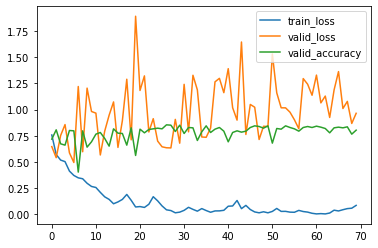

In [70]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [71]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.77432721583402
TEST
loss: 0.7592258042759366
accuracy: 0.7841269841269841
******************
epoch: 1
Train
0.569997343896778
TEST
loss: 0.7829496315547398
accuracy: 0.7428571428571429
******************
epoch: 2
Train
0.4991054967625734
TEST
loss: 0.4815539883242713
accuracy: 0.8095238095238095
******************
epoch: 3
Train
0.4745306428507077
TEST
loss: 0.6395643410228548
accuracy: 0.7238095238095238
******************
epoch: 4
Train
0.3968540081152185
TEST
loss: 0.5971391068564521
accuracy: 0.7904761904761904
******************
epoch: 5
Train
0.3550440158822216
TEST
loss: 0.6505914286961632
accuracy: 0.6793650793650794
******************
epoch: 6
Train
0.34415587207644205
TEST
loss: 0.537984358791321
accuracy: 0.8
******************
epoch: 7
Train
0.31155874735784495
TEST
loss: 0.6389762710011194
accuracy: 0.8031746031746032
******************
epoch: 8
Train
0.33599809553648763
TEST
loss: 1.226169130537245
accuracy: 0.685714285714285

In [72]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8223350253807107


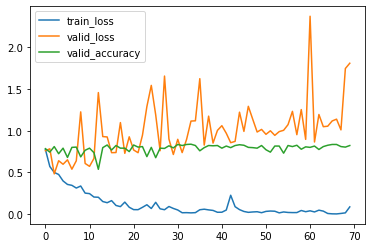

In [73]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [74]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.7991786079808205
TEST
loss: 0.6075430378081307
accuracy: 0.780952380952381
******************
epoch: 1
Train
0.604396718553459
TEST
loss: 0.8266335733353145
accuracy: 0.7142857142857143
******************
epoch: 2
Train
0.5599703160044311
TEST
loss: 0.5695115363787091
accuracy: 0.765079365079365
******************
epoch: 3
Train
0.5211192965507507
TEST
loss: 0.7317902691780575
accuracy: 0.7587301587301587
******************
epoch: 4
Train
0.47755780188785457
TEST
loss: 0.5623327665858798
accuracy: 0.7936507936507936
******************
epoch: 5
Train
0.44263579973964295
TEST
loss: 0.5204628724900503
accuracy: 0.7873015873015873
******************
epoch: 6
Train
0.38742288362421246
TEST
loss: 0.9122213021157279
accuracy: 0.5904761904761905
******************
epoch: 7
Train
0.36107108458533377
TEST
loss: 0.8095818606633989
accuracy: 0.6063492063492063
******************
epoch: 8
Train
0.4022800156090636
TEST
loss: 1.8993028368268694
accuracy:

In [75]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


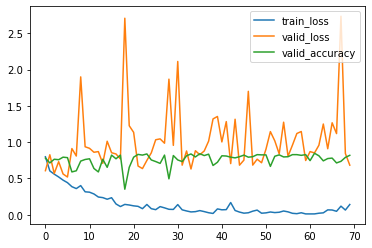

In [76]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [77]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8972171513308979
TEST
loss: 5.616930150228834
accuracy: 0.24444444444444444
******************
epoch: 1
Train
0.6538544815149072
TEST
loss: 0.5755288555508569
accuracy: 0.8
******************
epoch: 2
Train
0.5361318557957414
TEST
loss: 0.5143603398686364
accuracy: 0.8126984126984127
******************
epoch: 3
Train
0.5025282221194579
TEST
loss: 0.518212534321679
accuracy: 0.7904761904761904
******************
epoch: 4
Train
0.4584222077565879
TEST
loss: 0.5547464410463969
accuracy: 0.8031746031746032
******************
epoch: 5
Train
0.43583500097676625
TEST
loss: 0.5974195839866759
accuracy: 0.7968253968253968
******************
epoch: 6
Train
0.41841014187614345
TEST
loss: 0.677080760494111
accuracy: 0.7619047619047619
******************
epoch: 7
Train
0.393486644892204
TEST
loss: 0.5221432876965356
accuracy: 0.8031746031746032
******************
epoch: 8
Train
0.3574323320644445
TEST
loss: 0.7550714434139312
accuracy: 0.79365079365079

In [78]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8248730964467005


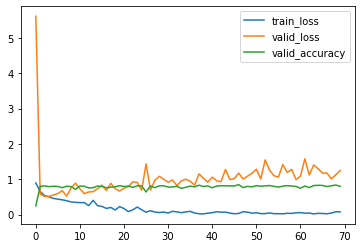

In [79]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()